In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 32
train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
import timm

model = timm.create_model("convnext_base", pretrained=False)
model.head.fc = nn.Linear(in_features=1024, out_features=10)

/home/server-96gb-ailab/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = model.to(device)

In [5]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]           6,272
       LayerNorm2d-2          [-1, 128, 56, 56]             256
          Identity-3          [-1, 128, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]           6,400
         LayerNorm-5          [-1, 56, 56, 128]             256
            Linear-6          [-1, 56, 56, 512]          66,048
              GELU-7          [-1, 56, 56, 512]               0
           Dropout-8          [-1, 56, 56, 512]               0
          Identity-9          [-1, 56, 56, 512]               0
           Linear-10          [-1, 56, 56, 128]          65,664
          Dropout-11          [-1, 56, 56, 128]               0
              Mlp-12          [-1, 56, 56, 128]               0
         Identity-13          [-1, 128, 56, 56]               0
         Identity-14          [-1, 128,

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 75

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/ 75] 	 Loss: 1.67216     Accuracy: 39.26% 	 Test Loss: 1.35965     Test Accuracy: 51.31%
Epoch [  2/ 75] 	 Loss: 1.21809     Accuracy: 55.84% 	 Test Loss: 1.11085     Test Accuracy: 60.35%
Epoch [  3/ 75] 	 Loss: 0.94383     Accuracy: 66.36% 	 Test Loss: 0.90375     Test Accuracy: 67.92%
Epoch [  4/ 75] 	 Loss: 0.74680     Accuracy: 73.65% 	 Test Loss: 0.78964     Test Accuracy: 72.02%
Epoch [  5/ 75] 	 Loss: 0.60041     Accuracy: 78.89% 	 Test Loss: 0.69052     Test Accuracy: 76.10%
Epoch [  6/ 75] 	 Loss: 0.47665     Accuracy: 83.16% 	 Test Loss: 0.65812     Test Accuracy: 77.33%
Epoch [  7/ 75] 	 Loss: 0.36727     Accuracy: 87.06% 	 Test Loss: 0.69288     Test Accuracy: 78.44%
Epoch [  8/ 75] 	 Loss: 0.26775     Accuracy: 90.60% 	 Test Loss: 0.76885     Test Accuracy: 77.99%
Epoch [  9/ 75] 	 Loss: 0.20030     Accuracy: 92.79% 	 Test Loss: 0.84996     Test Accuracy: 76.22%
Epoch [ 10/ 75] 	 Loss: 0.14752     Accuracy: 94.79% 	 Test Loss: 0.84257     Test Accuracy: 79.00%


KeyboardInterrupt: 

In [10]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 37 with test accuracy: 81.01%


# Plot results

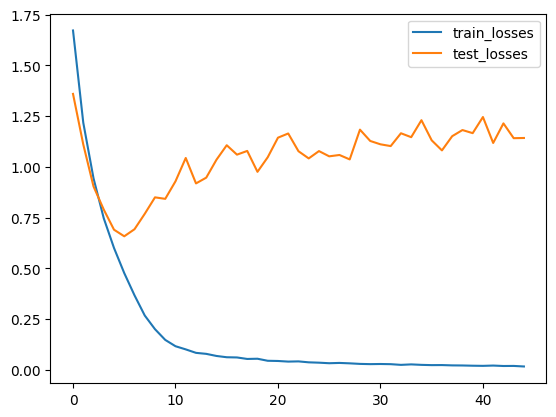

In [11]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

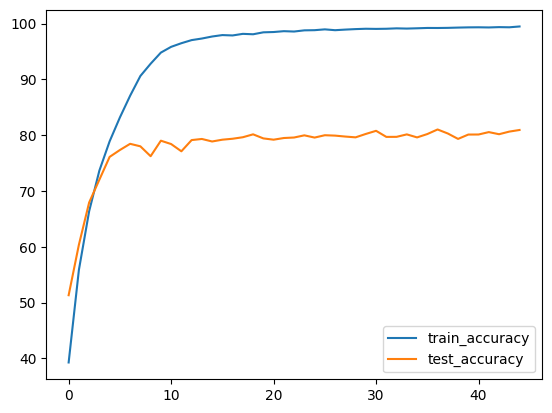

In [12]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()